In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from VindrMammoLoader import MammoDataset, MammoCompDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.ops.focal_loss import sigmoid_focal_loss
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Dataloader

In [2]:
image_datasets = {x: MammoDataset(phase=x,  seed =22) for x in ['train', 'val', 'test']}
batch_size = {'train':32, 'val':8, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=8, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['1','2','3', '4', '5']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)
print(dataset_sizes)

cuda:0 ['1', '2', '3', '4', '5']
{'train': 14396, 'val': 1604, 'test': 4000}


# Load saved model

In [3]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False )
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class SeverityModel(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self, path2pretrained='pretrained/best-contrastive50-2024-03-15.pt'):
        super(SeverityModel, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.bestsimese50simclr = SiameseNetwork101()
        state_dict = torch.load(path2pretrained)
        self.bestsimese50simclr.load_state_dict(state_dict)
        self.bestsimese50simclr.cnn1.add_module('fc2',
            nn.Sequential(torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
                        torch.nn.Dropout(0.1),
                        torch.nn.Linear(256, 256)))
    
    def forward_once(self, x):
        output = self.bestsimese50simclr.cnn1.fc2(self.bestsimese50simclr.cnn1(x))
        return output

    def forward(self, input1, input2, refinput):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        refinput = self.bestsimese50simclr.cnn1(refinput)
        return output1, output2, refinput

In [4]:
#SAVE then LOAD resnet50 weights for Inference

# # Save resnet50 from ConPrO weights
# bestsmodel = SeverityModel().to(device)
# state_dict = torch.load('/home/vishc1/hoang/pseudopapill/pretrained/best-smodel50-wofreeze-2024-03-24.pt')
# bestsmodel.load_state_dict(state_dict)
# bestsmodel.bestsimese50simclr.cnn1.fc = torch.nn.Sequential(*(list(bestsmodel.bestsimese50simclr.cnn1.fc)+list(bestsmodel.bestsimese50simclr.cnn1.fc2)))
# torch.save(bestsmodel.bestsimese50simclr.cnn1.state_dict(), f'pretrained/pretrained-resnet50-ConPro.pt')
# del bestsmodel
# # Save resnet50 from SupCon-2 weights
# smodel = SeverityModel(path2pretrained='pretrained/best-contrastive50-2024-03-15.pt').to(device)
# torch.save(smodel.bestsimese50simclr.cnn1.state_dict(), f'./pretrained/pretrained-resnet50-SupCon.pt')

# # Save resnet50 from SupCon-5 weights
#smodel5 = SeverityModel(path2pretrained='./pretrained/best-multiclass-contrastive50-2024-03-18.pt').to(device)
#torch.save(smodel5.bestsimese50simclr.cnn1.state_dict(), f'pretrained/pretrained-resnet50-SupCon5.pt')

# # Save resnet50 from Simclr weights
simclrweight = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr='/home/vishc1/hoang/simCLR-clone/runs/Mar21_17-27-27_huypn168/checkpoint_95_21032024.pth.tar')
torch.save(simclrweight.state_dict(), f'pretrained/pretrained-resnet50-SimCLR.pt')

load simclr resnet


In [5]:
pretrain_mode = 'SimCLR'

clf_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
clf_model.load_state_dict(torch.load(f'pretrained/pretrained-resnet50-{pretrain_mode}.pt'), strict=False)
clf_model.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))

In [6]:
def Focal_loss(class_logits,  labels):
    if class_logits.numel() == 0:
        return class_logits.new_zeros([1])[0]

    N = class_logits.shape[0]
    K = class_logits.shape[1] 

    target = class_logits.new_zeros(N, K)
    target[range(len(labels)), labels] = 1
    loss = sigmoid_focal_loss(class_logits, target, reduction = 'mean')
    return loss 

In [7]:
from sklearn.utils.class_weight import compute_class_weight
y= []
for _, y1 in tqdm(dataloaders['train']):
    y = y+ y1.tolist()
print(len(y))
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:51<00:00,  8.75it/s]

14396


array([ 0.29836269,  0.8553773 ,  4.31017964,  5.23490909, 17.77283951])

In [8]:
siamese50simclr = clf_model.to(device)
momentum = 0.9
lr = 0.001
optimizer_ft = optim.SGD([{'params': siamese50simclr.fc.parameters()}], lr=lr, momentum=momentum)
# optimizer_ft = optim.SGD([{'params': siamese50simclr.conv1.parameters()},
#                         {'params': siamese50simclr.layer1.parameters()},
#                         {'params':  siamese50simclr.layer2.parameters()},
#                         {'params': siamese50simclr.layer3.parameters()},
#                         {'params': siamese50simclr.layer4.parameters()},
#                         {'params': siamese50simclr.fc.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
class_weights=torch.tensor(class_weight,dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
#loss_fn= Focal_loss
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in siamese50simclr.parameters():
    param.requires_grad = False
for param in siamese50simclr.fc.parameters():
    param.requires_grad = True

In [9]:
from sklearn.metrics import f1_score
# bestmodel = siamese50simclr
f1max = 0
for e in range(20):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in tqdm(dataloaders['train'], total= len(dataloaders['train'])):
        siamese50simclr.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = siamese50simclr(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)
    predlist = []
    labelist = []
    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = siamese50simclr(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
        labelist.append(labels.detach().cpu().numpy()*1)
        predlist.append(preds.detach().cpu().numpy())
        val_acc += torch.sum(preds == labels.data)
    labelist = np.concatenate(labelist).ravel()
    predlist = np.concatenate(predlist).ravel()
    f1 = f1_score(predlist, labelist, average ='macro')
    if(f1 >= f1max):
        f1max = f1
        print(f"New best mode at epoch {e}")
        today = date.today()
        torch.save(siamese50simclr.state_dict(), f'pretrained/best-classification-siamese50simclr-SimCLR-{today}.pt')
    torch.save(siamese50simclr.state_dict(), f'pretrained/last-classification-siamese50simclr-SimCLR-{today}.pt')
    #scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'], "f1", f1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:56<00:00,  7.96it/s]


New best mode at epoch 0
E0 With LR 0.001 training acc:  0.3952486801889414 Val acc:  0.5548628428927681 traning loss:  1.5899672112752412 f1 0.18988106329581417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.12it/s]


New best mode at epoch 1
E1 With LR 0.001 training acc:  0.43519033064740203 Val acc:  0.5723192019950125 traning loss:  1.564874430436762 f1 0.2339485511742513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.12it/s]


E2 With LR 0.001 training acc:  0.4524868018894137 Val acc:  0.3933915211970075 traning loss:  1.5344653026565442 f1 0.20525334509912585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.13it/s]


E3 With LR 0.001 training acc:  0.44220616838010557 Val acc:  0.23379052369077308 traning loss:  1.5110807537071969 f1 0.15690675048908578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.15it/s]


E4 With LR 0.001 training acc:  0.37572936926924144 Val acc:  0.4014962593516209 traning loss:  1.50026195361966 f1 0.2235958162218677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.18it/s]


New best mode at epoch 5
E5 With LR 0.001 training acc:  0.39545707140872466 Val acc:  0.422069825436409 traning loss:  1.4854139537902697 f1 0.24375393862293646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.14it/s]


E6 With LR 0.001 training acc:  0.40309808280077797 Val acc:  0.45074812967581046 traning loss:  1.4782492092298978 f1 0.2425257466291349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.17it/s]


E7 With LR 0.001 training acc:  0.3993470408446791 Val acc:  0.3765586034912718 traning loss:  1.4681325842520037 f1 0.21178417798581167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.10it/s]


New best mode at epoch 8
E8 With LR 0.001 training acc:  0.40198666296193386 Val acc:  0.41458852867830426 traning loss:  1.4657636014214155 f1 0.25195779071481816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.13it/s]


E9 With LR 0.001 training acc:  0.37996665740483465 Val acc:  0.31733167082294267 traning loss:  1.4572633972894022 f1 0.21980098562597492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.12it/s]


New best mode at epoch 10
E10 With LR 0.001 training acc:  0.3748958043901084 Val acc:  0.4376558603491272 traning loss:  1.4436989176369401 f1 0.26075292502046804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:48<00:00,  9.22it/s]


New best mode at epoch 11
E11 With LR 0.001 training acc:  0.3858016115587663 Val acc:  0.42643391521197005 traning loss:  1.454368064522114 f1 0.26368708893860593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.15it/s]


New best mode at epoch 12
E12 With LR 0.001 training acc:  0.38955265351486523 Val acc:  0.43516209476309226 traning loss:  1.444794810358171 f1 0.2690231180472078


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.10it/s]


E13 With LR 0.001 training acc:  0.3687135315365379 Val acc:  0.3329177057356609 traning loss:  1.4347067668259756 f1 0.22160404491031627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.09it/s]


E14 With LR 0.001 training acc:  0.3768407891080856 Val acc:  0.44576059850374067 traning loss:  1.4309590535383816 f1 0.2609873678521106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.14it/s]


E15 With LR 0.001 training acc:  0.37329813837176995 Val acc:  0.26683291770573564 traning loss:  1.42608377088206 f1 0.18755332191934132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.14it/s]


New best mode at epoch 16
E16 With LR 0.001 training acc:  0.36669908307863297 Val acc:  0.4607231920199501 traning loss:  1.4216034703865486 f1 0.2719777562736413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.15it/s]


E17 With LR 0.001 training acc:  0.387329813837177 Val acc:  0.42144638403990026 traning loss:  1.415451991819746 f1 0.2505935538856881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.10it/s]


E18 With LR 0.001 training acc:  0.371561544873576 Val acc:  0.4869077306733167 traning loss:  1.4112996379346707 f1 0.26959354306354655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:49<00:00,  9.14it/s]


E19 With LR 0.001 training acc:  0.37871631008613504 Val acc:  0.35099750623441395 traning loss:  1.4026041844050796 f1 0.21965175398502162


In [10]:
bestmodel = models.resnet50(weights='ResNet50_Weights.DEFAULT')#get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
bestmodel.load_state_dict(torch.load(f'pretrained/best-classification-siamese50simclr-SimCLR-2024-03-25.pt'))
bestmodel.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
test_acc = 0
predlist = []
labelist = []
problist = []
# test_embeddings = torch.zeros((0, 2048))
sedis = 0
# fextractor = torch.nn.Sequential(*(list(clf_model.children())[:-1]))

for inputs, labels in dataloaders['test']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        # emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        # loss = loss_fn(outputs, labels)
        sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
# test_embeddings = np.array(test_embeddings)

# Result

In [12]:
print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.707     0.546     0.616      2682
           1      0.261     0.283     0.272       934
           2      0.078     0.258     0.120       186
           3      0.123     0.125     0.124       152
           4      0.172     0.565     0.264        46

    accuracy                          0.455      4000
   macro avg      0.268     0.355     0.279      4000
weighted avg      0.546     0.455     0.490      4000



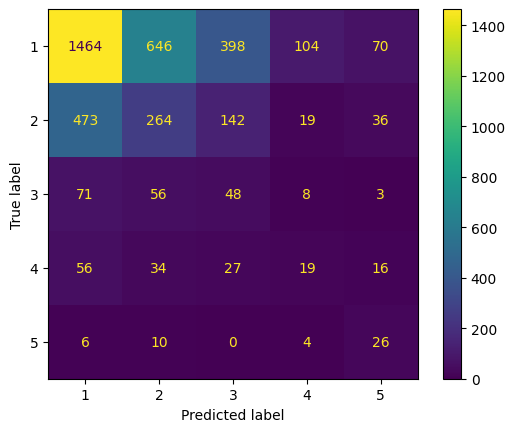

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()
